Epoch 1/2
6911/6911 [==============================] - 5s 728us/step - loss: 0.6305 - accuracy: 0.5895 - val_loss: 0.6503 - val_accuracy: 0.5665
Epoch 2/2
2160/2160 [==============================] - 1s 315us/step
F1 Score: 0.37
              precision    recall  f1-score   support

           0       0.91      0.55      0.69     57637
           1       0.25      0.73      0.37     11466

    accuracy                           0.58     69103
   macro avg       0.58      0.64      0.53     69103
weighted avg       0.80      0.58      0.64     69103

2160/2160 [==============================] - 1s 537us/step
F1 Score: 0.37
              precision    recall  f1-score   support

           0       0.91      0.55      0.69     57637
           1       0.25      0.73      0.37     11466

    accuracy                           0.58     69103
   macro avg       0.58      0.64      0.53     69103
weighted avg       0.80      0.58      0.64     69103



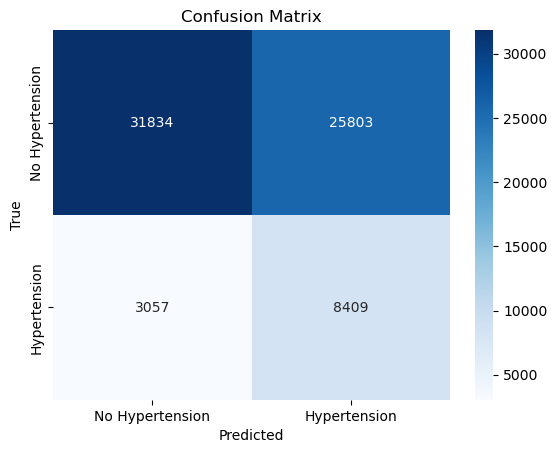

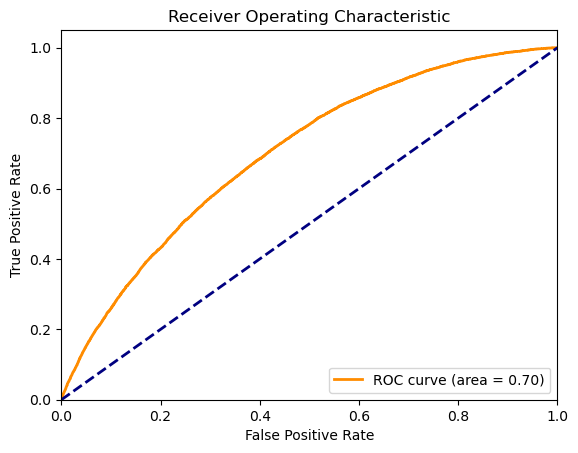

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

data = pd.read_csv('/Users/yeomsihun/Desktop/의료인공지능/sw응용/국민건강보험공단_건강검진정보_20221231.CSV', encoding='euc-kr')

data['고혈압여부'] = ((data['수축기혈압'] >= 140) | (data['이완기혈압'] >= 90)).astype(int)

data.drop(['혈청지오티(AST)', '혈청크레아티닌', '감마지티피', '혈색소', '요단백', '기준년도', '가입자일련번호', '시도코드', '구강검진수검여부', '총콜레스테롤', 'LDL콜레스테롤', '치아우식증유무', '치석', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '트리글리세라이드'], axis=1, inplace=True)

data = data.dropna()

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
X_train = train_data.drop(columns=['수축기혈압', '이완기혈압', '고혈압여부'])
y_train = train_data['고혈압여부']

X_test = test_data.drop(columns=['수축기혈압', '이완기혈압', '고혈압여부'])
y_test = test_data['고혈압여부']


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 클래스 가중치 계산
class_weights = {
    0: (1 / np.bincount(y_train)[0]) * len(y_train) / 2.0,
    1: (1 / np.bincount(y_train)[1]) * len(y_train) / 2.0
}

# 모델 구축
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=2, batch_size=32, verbose=1, validation_split=0.2, class_weight=class_weights)

y_pred = (model.predict(X_test) > 0.5).astype(int)


f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"F1 Score: {f1:.2f}")
print(report)
# 혼동 행렬 그리기
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Hypertension', 'Hypertension'], yticklabels=['No Hypertension', 'Hypertension'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# ROC 곡선 그리기
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

y_pred_prob = model.predict(X_test)
print(f"F1 Score: {f1:.2f}")
print(report)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred_prob)